# MapReduce on DecisionTree

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
from google.colab import drive
drive.mount('/content/drive')
cur_path = "/content/drive/MyDrive/Big Data Scaling Project/"
os.chdir(cur_path)
!pwd

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1AkachZiyb1r9EnxW_HsZQkk13UL_YKf_/Big Data Scaling Project


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

# Step 1

In [ ]:
df = pd.read_csv('adult.csv')
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [ ]:
import numpy as np

class DecisionTree:
    def __init__(self, max_depth=5, min_samples_leaf=5):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        

    def fit(self, X, y):
        self.num_classes = len(np.unique(y))
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        preds = []
        for x in X:
            pred = self._predict_recursive(x, self.tree)
            preds.append(pred)
        return np.array(preds)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_samples_per_class = [np.sum(y == i) for i in range(self.num_classes)]
        most_common_class = np.argmax(num_samples_per_class)

        if (depth == self.max_depth
                or num_samples < self.min_samples_leaf
                or len(np.unique(y)) == 1):
            return most_common_class

        feature_indices = np.random.choice(num_features, int(np.sqrt(num_features)), replace=False)

        best_feature, best_threshold = self._choose_best_feature(X, y, feature_indices)

        left_indices = np.where(X[:, best_feature] < best_threshold)[0]
        right_indices = np.where(X[:, best_feature] >= best_threshold)[0]

        left_tree = self._build_tree(X[left_indices, :], y[left_indices], depth+1)
        right_tree = self._build_tree(X[right_indices, :], y[right_indices], depth+1)

        return (best_feature, best_threshold, left_tree, right_tree)

    def _predict_recursive(self, x, tree):
        if isinstance(x, list):
            x = np.array(x)  # Convert list to numpy array
        elif not isinstance(x, np.ndarray):
            x = np.atleast_1d(x)  # Convert scalar to 1-dimensional numpy array

        if isinstance(tree, np.int64):
            return tree

        feature, threshold, left_tree, right_tree = tree
        if x[feature] < threshold:
            return self._predict_recursive(x, left_tree)
        else:
            return self._predict_recursive(x, right_tree)

    def _choose_best_feature(self, X, y, feature_indices):
        best_gain = -np.inf
        split_index, split_threshold = None, None
        for i in feature_indices:
            feature_values = X[:, i]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                gain = self._information_gain(X, y, i, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_index = i
                    split_threshold = threshold

        return split_index, split_threshold

    def _information_gain(self, X, y, split_index, split_threshold):
        parent_entropy = self._entropy(y)
        left_indices = np.where(X[:, split_index] < split_threshold)[0]
        right_indices = np.where(X[:, split_index] >= split_threshold)[0]
        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0
        left_entropy = self._entropy(y[left_indices])
        right_entropy = self._entropy(y[right_indices])
        num_left = len(left_indices)
        num_right = len(right_indices)
        child_entropy = (num_left / len(y)) * left_entropy + (num_right / len(y)) * right_entropy
        return parent_entropy - child_entropy

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities))

In [ ]:
# with open('adult100k', 'r') as file:
#     contents = file.read()

# # split the contents by newline character
# rows = contents.split('\n')

# # create a list of dictionaries where each dictionary corresponds to a row
# data = []
# for row in rows:
#     if row:  # ignore empty rows
#         row_values = row.split(',')
#         data.append({
#             'age': int(row_values[0]),
#             'workclass': row_values[1],
#             'fnlwgt': int(row_values[2]),
#             'education': row_values[3],
#             'education.num': int(row_values[4]),
#             'marital.status': row_values[5],
#             'occupation': row_values[6],
#             'relationship': row_values[7],
#             'race': row_values[8],
#             'sex': row_values[9],
#             'capital.gain': int(row_values[10]),
#             'capital.loss': int(row_values[11]),
#             'hours.per.week': int(row_values[12]),
#             'native-country': row_values[13],
#             'income': row_values[14]
#         })

# # create a Pandas DataFrame from the list of dictionaries
# df = pd.DataFrame(data)

df['income.num'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['income'].unique()

target = 'income.num'
features = ['age', 'education.num', 'hours.per.week','marital.status','race','sex','capital.gain','capital.loss','occupation','workclass']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

times = []
accuracies = []

for i in range(3,10):
    start_time = time.time()

    model = DecisionTree(max_depth=i)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    end_time = time.time()
    print("non-parallel time with "+str(i)+" max depth:", end_time - start_time, "seconds")
    times.append(end_time-start_time)

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print('accuracy with max depth of '+str(i)+': '+str(accuracy))

non-parallel time with 3 max depth: 0.7596981525421143 seconds
accuracy with max depth of 3: 0.8022315487767427
non-parallel time with 4 max depth: 1.0891473293304443 seconds
accuracy with max depth of 4: 0.8412324700583478
non-parallel time with 5 max depth: 1.8335902690887451 seconds
accuracy with max depth of 5: 0.8345787695772341
non-parallel time with 6 max depth: 2.1393723487854004 seconds
accuracy with max depth of 6: 0.8222950148428703
non-parallel time with 7 max depth: 1.7624266147613525 seconds
accuracy with max depth of 7: 0.8360118742962432
non-parallel time with 8 max depth: 1.5411241054534912 seconds
accuracy with max depth of 8: 0.8505476507319071
non-parallel time with 9 max depth: 2.2760369777679443 seconds
accuracy with max depth of 9: 0.8396970007165524


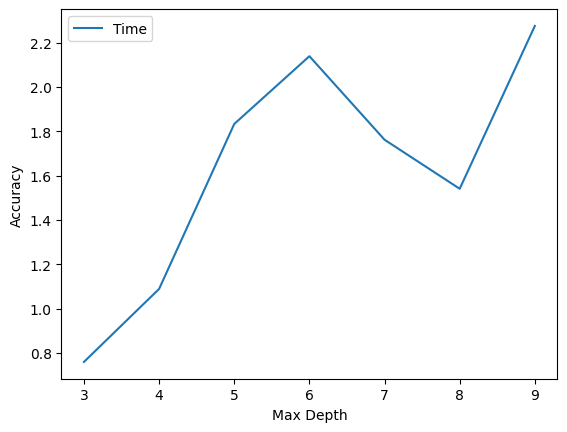

In [ ]:
import matplotlib.pyplot as plt

# Sample data
x = [3,4,5,6,7,8,9]

# Plot the data
#plt.plot(x, accuracies, label='Accuracies')
plt.plot(x, times, label='Time')

# Add a legend and axis labels
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

# Step 2

In [ ]:
import numpy as np
from multiprocessing import Pool

class DecisionTree_p:
    def __init__(self, max_depth=5, min_samples_leaf=5, n_jobs=1):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.n_jobs = n_jobs

    def fit(self, X, y):
        self.num_classes = len(np.unique(y))
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        preds = []
        for x in X:
            pred = self._predict_recursive(x, self.tree)
            preds.append(pred)
        return np.array(preds)

    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_samples_per_class = [np.sum(y == i) for i in range(self.num_classes)]
        most_common_class = np.argmax(num_samples_per_class)

        if (depth == self.max_depth
                or num_samples < self.min_samples_leaf
                or len(np.unique(y)) == 1):
            return most_common_class

        feature_indices = np.random.choice(num_features, int(np.sqrt(num_features)), replace=False)

        best_feature, best_threshold = self._choose_best_feature(X, y, feature_indices)

        left_indices = np.where(X[:, best_feature] < best_threshold)[0]
        right_indices = np.where(X[:, best_feature] >= best_threshold)[0]

        left_tree = None
        right_tree = None

        if self.n_jobs == 1:
            left_tree = self._build_tree(X[left_indices, :], y[left_indices], depth+1)
            right_tree = self._build_tree(X[right_indices, :], y[right_indices], depth+1)
        else:
            with Pool(self.n_jobs) as p:
                left_tree = p.apply_async(self._build_tree, args=(X[left_indices, :], y[left_indices], depth+1))
                right_tree = p.apply_async(self._build_tree, args=(X[right_indices, :], y[right_indices], depth+1))
                left_tree = left_tree.get()
                right_tree = right_tree.get()

        return (best_feature, best_threshold, left_tree, right_tree)

    def _predict_recursive(self, x, tree):
        if isinstance(x, list):
            x = np.array(x)  # Convert list to numpy array
        elif not isinstance(x, np.ndarray):
            x = np.atleast_1d(x)  # Convert scalar to 1-dimensional numpy array

        if isinstance(tree, np.int64):
            return tree

        feature, threshold, left_tree, right_tree = tree
        if x[feature] < threshold:
            return self._predict_recursive(x, left_tree)
        else:
            return self._predict_recursive(x, right_tree)

    def _choose_best_feature(self, X, y, feature_indices):
        best_gain = -np.inf
        split_index, split_threshold = None, None
        for i in feature_indices:
            feature_values = X[:, i]
            thresholds = np.unique(feature_values)
            for threshold in thresholds:
                gain = self._information_gain(X, y, i, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_index = i
                    split_threshold = threshold

        return split_index, split_threshold

    def _information_gain(self, X, y, split_index, split_threshold):
        parent_entropy = self._entropy(y)
        left_indices = np.where(X[:, split_index] < split_threshold)[0]
        right_indices = np.where(X[:, split_index] >= split_threshold)[0]
        if len(left_indices) == 0 or len(right_indices) == 0:
            return 0
        left_entropy = self._entropy(y[left_indices])
        right_entropy = self._entropy(y[right_indices])
        num_left = len(left_indices)
        num_right = len(right_indices)
        child_entropy = (num_left / len(y)) * left_entropy + (num_right / len(y)) * right_entropy
        return parent_entropy - child_entropy

    def _entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities))


In [ ]:
df = pd.read_csv('adult.csv')

In [ ]:
df['income.num'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['income'].unique()

target = 'income.num'
features = ['age', 'education.num', 'hours.per.week']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

#nonparallel
start_time = time.time()

model = DecisionTree(max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

end_time = time.time()
print("non-parallel time:", end_time - start_time, "seconds")

#parallel
start_time = time.time()

model_p = DecisionTree_p(max_depth=5)
model_p.fit(X_train, y_train)
y_pred_p = model_p.predict(X_test)

end_time = time.time()
print("parallel time:", end_time - start_time, "seconds")

accuracy_p = accuracy_score(y_test, y_pred_p)
accuracy_p

non-parallel time: 0.3136909008026123 seconds
parallel time: 0.37381815910339355 seconds


0.7934281912171154

In [ ]:
with open('adult100k', 'r') as file:
    contents = file.read()

# split the contents by newline character
rows = contents.split('\n')

# create a list of dictionaries where each dictionary corresponds to a row
data = []
for row in rows:
    if row:  # ignore empty rows
        row_values = row.split(',')
        data.append({
            'age': int(row_values[0]),
            'workclass': row_values[1],
            'fnlwgt': int(row_values[2]),
            'education': row_values[3],
            'education.num': int(row_values[4]),
            'marital.status': row_values[5],
            'occupation': row_values[6],
            'relationship': row_values[7],
            'race': row_values[8],
            'sex': row_values[9],
            'capital.gain': int(row_values[10]),
            'capital.loss': int(row_values[11]),
            'hours.per.week': int(row_values[12]),
            'native-country': row_values[13],
            'income': row_values[14]
        })

# create a Pandas DataFrame from the list of dictionaries
df = pd.DataFrame(data)


df['income.num'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['income'].unique()

target = 'income.num'
features = ['age', 'education.num', 'hours.per.week','marital.status','race','sex','capital.gain','capital.loss','occupation','workclass']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

#nonparallel
start_time = time.time()

model = DecisionTree(max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

end_time = time.time()
print("non-parallel time:", end_time - start_time, "seconds")

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
#parallel
start_time = time.time()

model_p = DecisionTree_p(max_depth=5)
model_p.fit(X_train, y_train)
y_pred_p = model_p.predict(X_test)

end_time = time.time()
print("parallel time:", end_time - start_time, "seconds")

accuracy_p = accuracy_score(y_test, y_pred_p)
print(accuracy_p)

non-parallel time: 10.751235485076904 seconds
0.6027333333333333
parallel time: 5.623666286468506 seconds


0.6107666666666667

In [ ]:
with open('adult1m', 'r') as file:
    contents = file.read()

# split the contents by newline character
rows = contents.split('\n')

# create a list of dictionaries where each dictionary corresponds to a row
data = []
for row in rows:
    if row:  # ignore empty rows
        row_values = row.split(',')
        data.append({
            'age': int(row_values[0]),
            'workclass': row_values[1],
            'fnlwgt': int(row_values[2]),
            'education': row_values[3],
            'education.num': int(row_values[4]),
            'marital.status': row_values[5],
            'occupation': row_values[6],
            'relationship': row_values[7],
            'race': row_values[8],
            'sex': row_values[9],
            'capital.gain': int(row_values[10]),
            'capital.loss': int(row_values[11]),
            'hours.per.week': int(row_values[12]),
            'native-country': row_values[13],
            'income': row_values[14]
        })

# create a Pandas DataFrame from the list of dictionaries
df = pd.DataFrame(data)
df['income.num'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['income'].unique()

target = 'income.num'
features = ['age', 'education.num', 'hours.per.week','marital.status','race','sex','capital.gain','capital.loss','occupation','workclass']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

#nonparallel
start_time = time.time()

model = DecisionTree(max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

end_time = time.time()
print("non-parallel time:", end_time - start_time, "seconds")

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
#parallel
start_time = time.time()

model_p = DecisionTree_p(max_depth=5)
model_p.fit(X_train, y_train)
y_pred_p = model_p.predict(X_test)

end_time = time.time()
print("parallel time:", end_time - start_time, "seconds")

accuracy_p = accuracy_score(y_test, y_pred_p)
print(accuracy_p)

non-parallel time: 96.11704182624817 seconds
0.5109533333333334
parallel time: 86.39976978302002 seconds


0.50904

In [ ]:
with open('adult100m', 'r') as file:
    contents = file.read()

# split the contents by newline character
rows = contents.split('\n')

# create a list of dictionaries where each dictionary corresponds to a row
data = []
for row in rows:
    if row:  # ignore empty rows
        row_values = row.split(',')
        data.append({
            'age': int(row_values[0]),
            'workclass': row_values[1],
            'fnlwgt': int(row_values[2]),
            'education': row_values[3],
            'education.num': int(row_values[4]),
            'marital.status': row_values[5],
            'occupation': row_values[6],
            'relationship': row_values[7],
            'race': row_values[8],
            'sex': row_values[9],
            'capital.gain': int(row_values[10]),
            'capital.loss': int(row_values[11]),
            'hours.per.week': int(row_values[12]),
            'native-country': row_values[13],
            'income': row_values[14]
        })

# create a Pandas DataFrame from the list of dictionaries
df = pd.DataFrame(data)
df['income.num'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['income'].unique()

target = 'income.num'
features = ['age', 'education.num', 'hours.per.week','marital.status','race','sex','capital.gain','capital.loss','occupation','workclass']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

#nonparallel
start_time = time.time()

model = DecisionTree(max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

end_time = time.time()
print("non-parallel time:", end_time - start_time, "seconds")

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
#parallel
start_time = time.time()

model_p = DecisionTree_p(max_depth=5)
model_p.fit(X_train, y_train)
y_pred_p = model_p.predict(X_test)

end_time = time.time()
print("parallel time:", end_time - start_time, "seconds")

accuracy_p = accuracy_score(y_test, y_pred_p)
print(accuracy_p)

In [ ]:
with open('adult10m', 'r') as file:
    contents = file.read()

# split the contents by newline character
rows = contents.split('\n')

# create a list of dictionaries where each dictionary corresponds to a row
data = []
for row in rows:
    if row:  # ignore empty rows
        row_values = row.split(',')
        data.append({
            'age': int(row_values[0]),
            'workclass': row_values[1],
            'fnlwgt': int(row_values[2]),
            'education': row_values[3],
            'education.num': int(row_values[4]),
            'marital.status': row_values[5],
            'occupation': row_values[6],
            'relationship': row_values[7],
            'race': row_values[8],
            'sex': row_values[9],
            'capital.gain': int(row_values[10]),
            'capital.loss': int(row_values[11]),
            'hours.per.week': int(row_values[12]),
            'native-country': row_values[13],
            'income': row_values[14]
        })

# create a Pandas DataFrame from the list of dictionaries
df = pd.DataFrame(data)
df['income.num'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['income'].unique()

target = 'income.num'
df['income.num'] = df['income'].map({'<=50K': 0, '>50K': 1})
df['income'].unique()

target = 'income.num'
features = ['age', 'education.num', 'hours.per.week','marital.status','race','sex','capital.gain','capital.loss','occupation','workclass']

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

#nonparallel
start_time = time.time()

model = DecisionTree(max_depth=5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

end_time = time.time()
print("non-parallel time:", end_time - start_time, "seconds")

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
#parallel
start_time = time.time()

model_p = DecisionTree_p(max_depth=5)
model_p.fit(X_train, y_train)
y_pred_p = model_p.predict(X_test)

end_time = time.time()
print("parallel time:", end_time - start_time, "seconds")

accuracy_p = accuracy_score(y_test, y_pred_p)
print(accuracy_p)

FileNotFoundError: ignored